In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告信息

# 设置中文字体
matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

## 数据导入与预处理

In [2]:
### 表1数据处理
data1 = pd.read_csv("../处理后的数据/表1-患者列表及临床信息.csv")
df_data1 = data1[["ID", "发病到首次影像检查时间间隔"]]
df_data1 = df_data1[df_data1["ID"] < "sub101"]
result_q1a = pd.read_csv('../output/result_q1a.csv')
df_data1 = pd.merge(df_data1, result_q1a, on=["ID"], how="left")
df_data1

,ID,发病到首次影像检查时间间隔,是否发生血肿扩张
0,sub001,2.5,0
1,sub002,3.0,0
2,sub003,2.0,1
3,sub004,1.0,0
4,sub005,5.0,1
...,...,...,...
95,sub096,1.0,0
96,sub097,3.0,0
97,sub098,2.5,1
98,sub099,3.0,1


In [3]:
### 表2数据处理
data2 = pd.read_csv("../处理后的数据/表2-血肿及水肿的体积及位置.csv")
## 表2保留特定列
df_data2 = data2[["ID", "流水号", "ED_volume"]]
### 保留表2 sub001-sub100
df_data2 = df_data2[df_data2["ID"] < "sub101"]
df_data2.head()

,ID,流水号,ED_volume
0,sub001,20161212002136,48919.0
1,sub001,20161213000009,57898.0
2,sub001,20161218000100,81747.0
3,sub001,20161223001020,107793.0
4,sub001,20161230000574,126558.0


In [4]:
time_data = pd.read_csv("../处理后的数据/附表1-时间点-流水号.csv")
df_time_number = time_data[['流水号', '随访时间点', '检查次序', '重复次数']]
df_time_number["流水号"] = df_time_number['流水号'].apply(lambda x: int(x))
df_time_number

,流水号,随访时间点,检查次序,重复次数
0,20161212002136,2016-12-12 23:32:54,0,5
1,20160406002131,2016-04-06 21:21:03,0,5
2,20160413000006,2016-04-13 01:18:17,0,3
3,20161215001667,2016-12-15 22:53:41,0,4
4,20161222000978,2016-12-22 13:18:48,0,3
...,...,...,...,...
657,20180126000567,2018-01-26 09:57:26,8,13
658,20180201000828,2018-02-01 10:32:30,9,13
659,20180213000362,2018-02-13 09:48:21,10,13
660,20180316001622,2018-03-16 15:38:42,11,13


In [5]:
df_data1.shape, df_data2.shape, df_time_number.shape

((100, 3), (450, 3), (662, 4))

### 数据合并与提取

In [6]:
### 将df_time_number和df_data2合并
df = pd.merge(df_data2, df_time_number, on=["流水号"], how="left")
df = pd.merge(df, df_data1, on=["ID"], how="left")
# 排序，重置索引，按照ID，检查次序排序
df = df.sort_values(by=["ID", "检查次序"]).reset_index(drop=True)
df["发病到首次影像检查时间间隔"] = df["发病到首次影像检查时间间隔"] * 3600  # 将小时转化为秒
## 时间数据转换
df["随访时间点"] = pd.to_datetime(df["随访时间点"])
df

,ID,流水号,ED_volume,随访时间点,检查次序,重复次数,发病到首次影像检查时间间隔,是否发生血肿扩张
0,sub001,20161212002136,48919.0,2016-12-12 23:32:54,0,5,9000.0,0
1,sub001,20161213000009,57898.0,2016-12-13 05:19:00,1,5,9000.0,0
2,sub001,20161218000100,81747.0,2016-12-18 09:09:24,2,5,9000.0,0
3,sub001,20161223001020,107793.0,2016-12-23 16:47:09,3,5,9000.0,0
4,sub001,20161230000574,126558.0,2016-12-30 14:35:12,4,5,9000.0,0
...,...,...,...,...,...,...,...,...
445,sub099,20180621000781,19517.0,2018-06-21 09:43:31,1,3,10800.0,1
446,sub099,20180622000871,30933.0,2018-06-22 10:34:55,2,3,10800.0,1
447,sub100,20180314000010,7367.0,2018-03-14 04:46:39,0,3,1800.0,0
448,sub100,20180315001448,6033.0,2018-03-15 15:00:31,1,3,1800.0,0


In [7]:
### 计算发病到检查的时间间隔
# df["时间差"] = df.groupby("ID")["随访时间点"].diff().dt.days  # 一个很好用的函数，不过在这里不适用
## 循环遍历每一个ID，计算时间差
time_diff = []
for i in range(1, 101):
    temp = df[df["ID"] == f"sub{i:03d}"]
    temp.reset_index(drop=True, inplace=True)  # 要重置临时表的索引，否则 temp["随访时间点"][0] 会报错
    temp_list = (temp["随访时间点"] - temp["随访时间点"][0]).dt.total_seconds().tolist()  # 时间差转化为了秒
    for j in range(len(temp_list)):
        time_diff.append(temp_list[j] + temp["发病到首次影像检查时间间隔"][j])

df['发病到检查时间间隔'] = time_diff
df = df[['ID', '流水号', 'ED_volume', '发病到检查时间间隔',"是否发生血肿扩张"]]
df.to_csv("../output/df_q2a.csv", index=False)
df

,ID,流水号,ED_volume,发病到检查时间间隔,是否发生血肿扩张
0,sub001,20161212002136,48919.0,9000.0,0
1,sub001,20161213000009,57898.0,29766.0,0
2,sub001,20161218000100,81747.0,475590.0,0
3,sub001,20161223001020,107793.0,935055.0,0
4,sub001,20161230000574,126558.0,1531938.0,0
...,...,...,...,...,...
445,sub099,20180621000781,19517.0,63622.0,1
446,sub099,20180622000871,30933.0,153106.0,1
447,sub100,20180314000010,7367.0,1800.0,0
448,sub100,20180315001448,6033.0,125032.0,0


In [8]:
# 打印包含缺失值的行
df[df.isna().any(axis=1)]

,ID,流水号,ED_volume,发病到检查时间间隔,是否发生血肿扩张


In [10]:
df[df["ED_volume"] == 0]

,ID,流水号,ED_volume,发病到检查时间间隔,是否发生血肿扩张
9,sub002,20160523000682,0.0,4029091.0,0
43,sub010,20161121000681,0.0,3425578.0,0
82,sub019,20160331000374,0.0,6423754.0,0
86,sub020,20160822000964,0.0,2623363.0,0
87,sub020,20160930001099,0.0,6005977.0,0
105,sub024,20170821000373,0.0,1657130.0,0
142,sub033,20170219000392,0.0,3043977.0,1
225,sub051,20170613001234,0.0,4489359.0,0
230,sub052,20170821000313,0.0,6389871.0,0
231,sub052,20171214000321,0.0,16327159.0,0


In [11]:
df.shape

(450, 5)

## 数据绘图

### 散点图

<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume'>

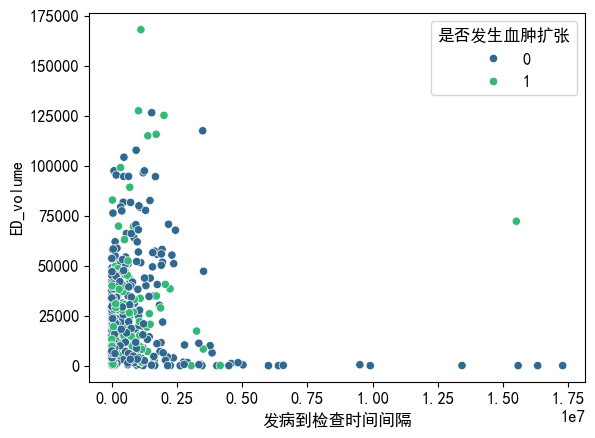

In [12]:
sns.scatterplot(data=df, x="发病到检查时间间隔", y="ED_volume", hue="是否发生血肿扩张", palette="viridis")

In [18]:
df1 = df[df["发病到检查时间间隔"] <= 172800]
df1.shape

(212, 5)

In [19]:
df1[df1["ED_volume"] == 0]

,ID,流水号,ED_volume,发病到检查时间间隔,是否发生血肿扩张


<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume'>

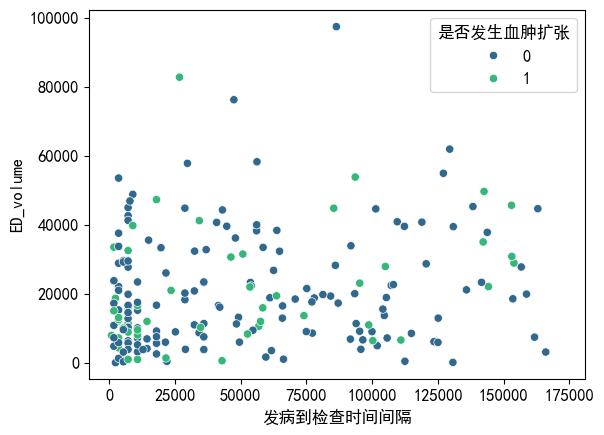

In [20]:
# 绘制散点图
# plt.figure(figsize=(10, 6))  # 指定画布大小
sns.scatterplot(data=df1, x="发病到检查时间间隔", y="ED_volume", hue="是否发生血肿扩张", palette="viridis")
# , style="smoker"  # "是否发生血肿扩张"  # s=100, 

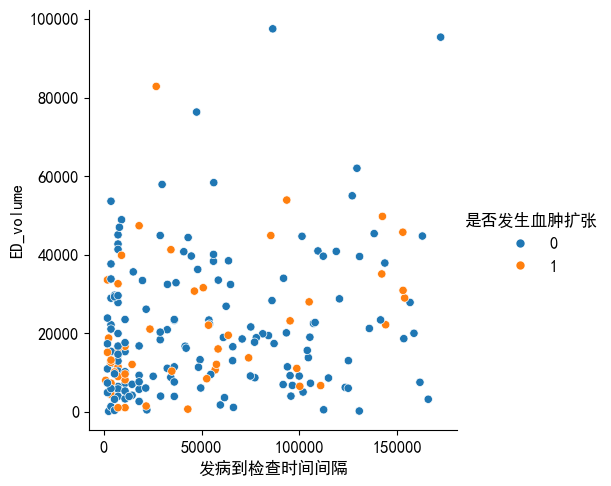

In [314]:
sns.relplot(data=df1, x="发病到检查时间间隔", y="ED_volume", hue="是否发生血肿扩张")
# sns.relplot(data=df, x="发病到检查时间间隔", y="ED_volume", hue="是否发生血肿扩张")

### 折线图

sns.lineplot在这里报错，还调不好，不用他了

### 对数散点图

<AxesSubplot:xlabel='发病到检查时间间隔', ylabel='log_ED_volume'>

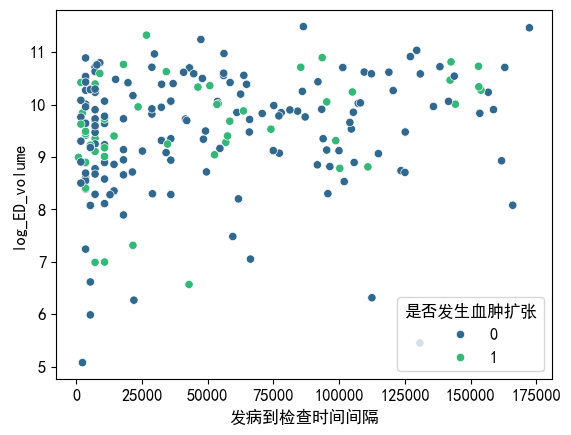

In [316]:
# 对体积做对数变换后再绘图
df["log_ED_volume"] = np.log(df["ED_volume"].astype(float))
df["log_发病到检查时间间隔"] = np.log(df["发病到检查时间间隔"].astype(float))
df1 = df[df["发病到检查时间间隔"] <= 172800]
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x="发病到检查时间间隔", y="log_ED_volume", hue="是否发生血肿扩张", palette="viridis")

### box-cox变换后的散点图
### 平方根变换后的散点图

<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume_transformed'>

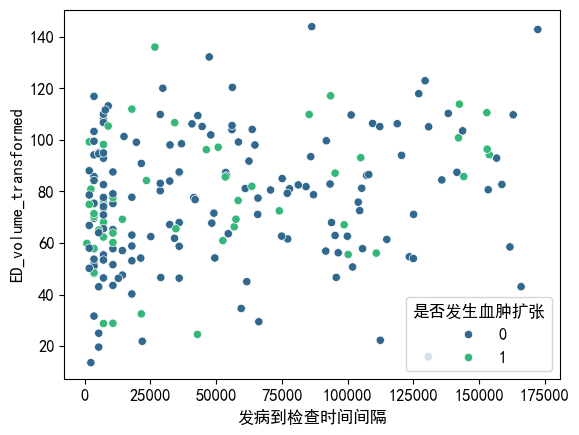

In [21]:
## box-cox 变换
from scipy.stats import boxcox
df1['ED_volume_transformed'], _ = boxcox(df1['ED_volume'])
sns.scatterplot(data=df1, x="发病到检查时间间隔", y="ED_volume_transformed", hue="是否发生血肿扩张", palette="viridis")

## 曲线拟合

In [33]:
# 数据提取
x = np.array(df1["发病到检查时间间隔"])
y = np.array(df1["ED_volume"])

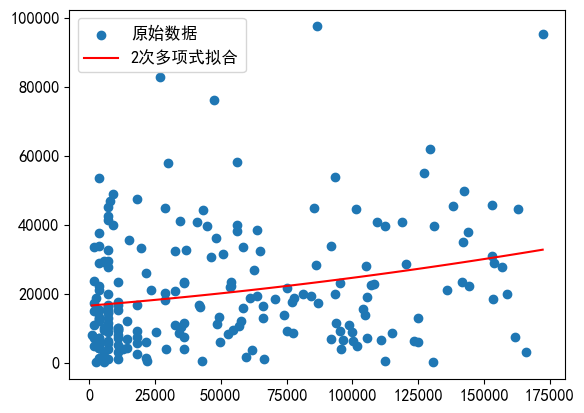

In [41]:
## 多项式拟合（例如二次多项式）
degree = 2
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label="原始数据")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, color="red", label=f"{degree}次多项式拟合")
plt.legend()
plt.show()

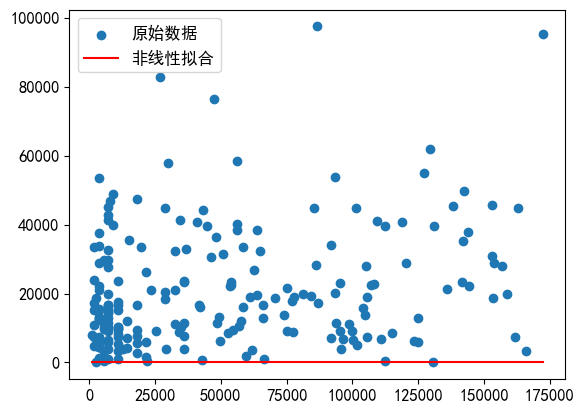

In [ ]:
## 非线性拟合
from scipy.optimize import curve_fit

# 定义拟合函数
def func(x, a, b):
    return a * np.exp(-b * x)

# 非线性拟合
popt, pcov = curve_fit(func, x, y, p0=[1, 0.1])  # p0是初始参数估计

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label="原始数据")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, color="red", label="非线性拟合")
plt.legend()
plt.show()

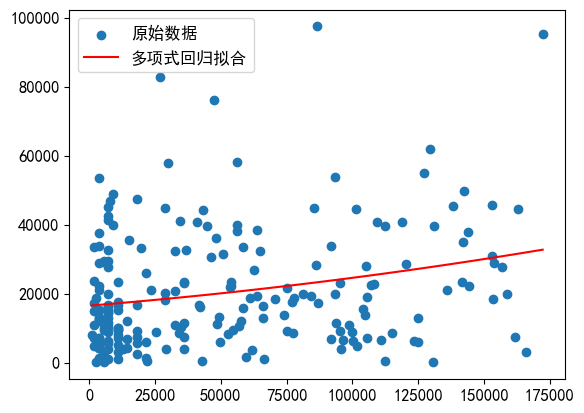

In [38]:
## 基于机器学习的拟合
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 多项式特征转换
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

# 拟合多项式回归模型
model = LinearRegression()
model.fit(x_poly, y)

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label="原始数据")
x_fit = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_fit = model.predict(poly.transform(x_fit))
plt.plot(x_fit, y_fit, color="red", label="多项式回归拟合")
plt.legend()
plt.show()

感觉前面的多项式拟合还是比较不错的。

拟合的多项式函数为：
          2
1.86e-07 x + 0.06199 x + 1.663e+04


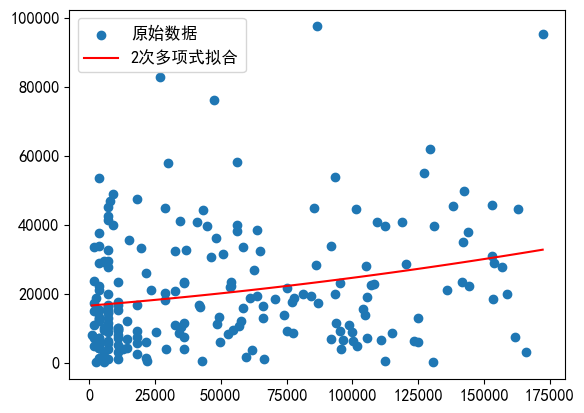

In [43]:
## 多项式拟合（例如二次多项式）
degree = 2
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

# 打印拟合的函数
print("拟合的多项式函数为：")
print(polynomial)

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label="原始数据")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, color="red", label=f"{degree}次多项式拟合")
plt.legend()
plt.show()

拟合的多项式函数为：
 
0.08793 x + 1.622e+04


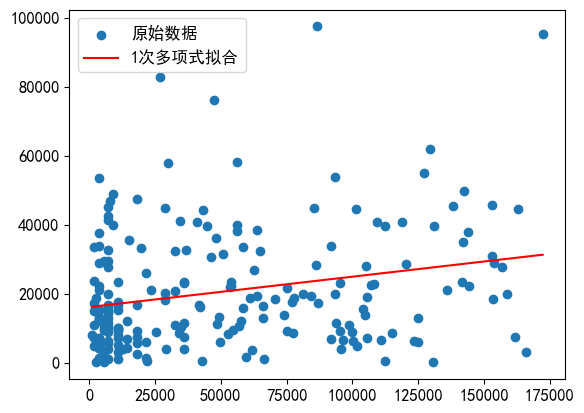

In [44]:
## 一次多项式拟合
degree = 1
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

# 打印拟合的函数
print("拟合的多项式函数为：")
print(polynomial)

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label="原始数据")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, color="red", label=f"{degree}次多项式拟合")
plt.legend()
plt.show()